<a href="https://colab.research.google.com/github/JordanSmithPhD/GNAR_Income/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


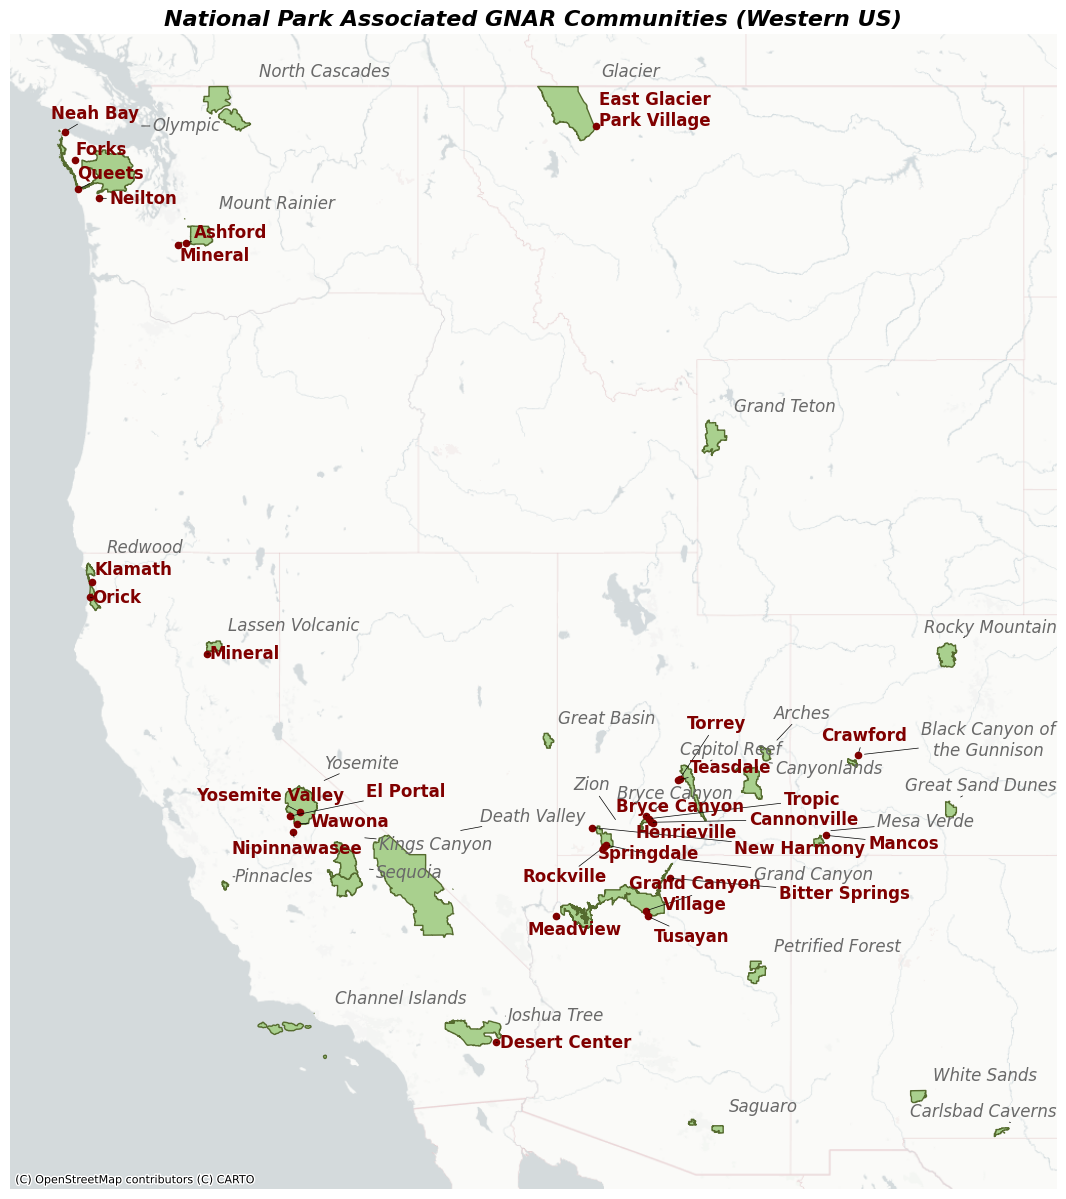

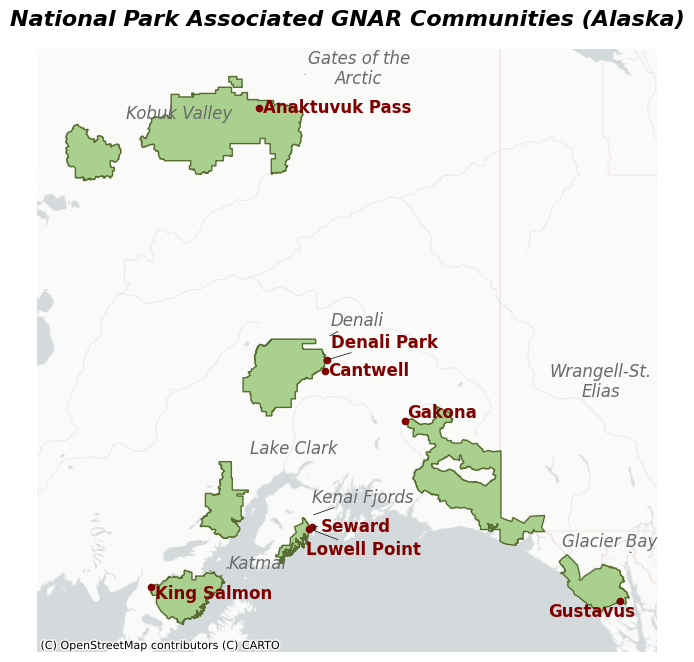

In [ ]:
## Create Figure 1.
!pip install contextily
!pip install adjustText

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import box
from shapely.affinity import translate
from adjustText import adjust_text

# Helper Functions
def clean_labels(df, column, replacements):
    """Clean a GeoDataFrame column with multiple replacements."""
    for old, new in replacements.items():
        df[column] = df[column].str.replace(old, new, regex=True).str.strip()

def get_outside_label_position_bounding_box(geometry, x_offset=10000, y_offset=10000):
    """Calculate label position outside the polygon's bounding box."""
    bounds = geometry.bounds  # (minx, miny, maxx, maxy)
    x = bounds[2] + x_offset  # Position to the right
    y = bounds[3] + y_offset  # Position above
    return x, y

def split_label(label, max_length=16):
    """Split a label into multiple lines without breaking words."""
    words = label.split()
    lines, current_line = [], words[0]
    for word in words[1:]:
        if len(current_line) + len(word) + 1 <= max_length:
            current_line += f" {word}"
        else:
            lines.append(current_line)
            current_line = word
    lines.append(current_line)  # Append final line
    return "\n".join(lines)

def plot_map(ax, parks_gdf, points_gdf, title, file_prefix):
    """Generalized function for plotting the map."""
    # Plot parks
    parks_gdf.plot(ax=ax, facecolor="#A9D08E", edgecolor="darkolivegreen", linewidth=1, label="National Parks")

    # Plot GNAR points
    points_gdf.plot(ax=ax, color="maroon", markersize=20, label="GNAR Communities")

    # Add basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, crs=parks_gdf.crs.to_string())

    # Add labels
    texts = []
    for x, y, label in zip(points_gdf.geometry.x, points_gdf.geometry.y, points_gdf["NAMELSAD"]):
        formatted_label = split_label(label)
        texts.append(ax.text(x, y, formatted_label, fontsize=12, color="maroon", weight="bold"))

    for geom, label in zip(parks_gdf.geometry, parks_gdf["UNIT_NAME"]):
        label_position = get_outside_label_position_bounding_box(geom)
        formatted_label = split_label(label)
        texts.append(ax.text(label_position[0], label_position[1], formatted_label, fontsize=12, color="dimgrey", style="italic"))

    # Adjust text labels
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color="k", lw=0.5))

    # Title and aesthetics
    ax.set_title(title, fontsize=16, color="black", weight="bold", style="italic")
    ax.axis("off")

    # Save figures
    fig.savefig(f"{file_prefix}_map_high_res.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"{file_prefix}_map.pdf", format="pdf", bbox_inches="tight")

# File Paths
points_shapefile_path = "/[YOUR LOCAL DRIVE HERE]/Centroids_with_GNAR_updated_with_driving_dist.shp"
parks_shapefile_path = "/[YOUR LOCAL DRIVE HERE]/Filtered_nps_boundary.shp"

# Load GeoDataFrames
points_gdf = gpd.read_file(points_shapefile_path)
parks_gdf = gpd.read_file(parks_shapefile_path)

# Ensure CRS consistency
points_gdf = points_gdf.to_crs(epsg=3857)
parks_gdf = parks_gdf.to_crs(points_gdf.crs)

# Clean labels
clean_labels(points_gdf, "NAMELSAD", {"CDP": "", "town": "", "city": "", "City": ""})
clean_labels(parks_gdf, "UNIT_NAME", {"National Park": ""})

# Filter GNAR points
gnar_points_gdf = points_gdf[points_gdf["GNAR"] == 1]

# Define bounds
continental_us_bounds = gpd.GeoSeries([box(-130, 24, -65, 50)], crs="EPSG:4326").to_crs(epsg=3857).total_bounds
alaska_bounds = gpd.GeoSeries([box(-180, 50, -120, 72)], crs="EPSG:4326").to_crs(epsg=3857).total_bounds

# Filter data by region
continental_us_gdf = parks_gdf.cx[continental_us_bounds[0]:continental_us_bounds[2], continental_us_bounds[1]:continental_us_bounds[3]]
alaska_gdf = parks_gdf.cx[alaska_bounds[0]:alaska_bounds[2], alaska_bounds[1]:alaska_bounds[3]]
gnar_points_continental = gnar_points_gdf.cx[continental_us_bounds[0]:continental_us_bounds[2], continental_us_bounds[1]:continental_us_bounds[3]]
gnar_points_alaska = gnar_points_gdf.cx[alaska_bounds[0]:alaska_bounds[2], alaska_bounds[1]:alaska_bounds[3]]

# Plot Continental US Map
fig, ax_main = plt.subplots(figsize=(24, 15))
plot_map(ax_main, continental_us_gdf, gnar_points_continental, "National Park Associated GNAR Communities (Western US)", "continental_us")

# Plot Alaska Map
fig, ax_inset = plt.subplots(figsize=(8, 8))
plot_map(ax_inset, alaska_gdf, gnar_points_alaska, "National Park Associated GNAR Communities (Alaska)", "alaska")

In [ ]:
## Calculate the margin of error for the pct_sro_hu variable.
import pandas as pd
import numpy as np

# File path for the uploaded dataset
file_path = "/[YOUR LOCAL DRIVE HERE]/NP_associated_GNARs_2010_2023_Benchmark.csv"

# Read the dataset
data = pd.read_csv(file_path)

# Calculate the new variable 'pct_sro_hu'
data['pct_sro_hu'] = data['sro_hu'] / data['hu_tot']

# Calculate the new variable 'pct_sro_hu_m'
data['pct_sro_hu_m'] = (1 / (data['hu_tot_m'])) * np.sqrt(((data['sro_hu_m']) ** 2) - (((data['pct_sro_hu']) ** 2) * (data['hu_tot_m']) ** 2))

# Reorder columns to place 'pct_sro_hu_m' immediately after 'pct_sro_hu'
columns = list(data.columns)
if 'pct_sro_hu' in columns and 'pct_sro_hu_m' in columns:
    pct_sro_hu_index = columns.index('pct_sro_hu')
    # Remove 'pct_sro_hu_m' from the end
    columns.remove('pct_sro_hu_m')
    # Insert 'pct_sro_hu_m' after 'pct_sro_hu'
    columns.insert(pct_sro_hu_index + 1, 'pct_sro_hu_m')

# Reorder the dataframe
data = data[columns]

# Save the updated dataset to a new file
updated_file_path = 'NP_associated_GNARs_2010_2023_Full.csv'
data.to_csv(updated_file_path, index=False)

updated_file_path

<ipython-input-2-96b909c7dde7>:9: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


'NP_associated_GNARs_2010_2023_Full.csv'

In [ ]:
## Calculate proportional variables, growth rates, and adjust income values for inflation. Create a table of summary statistics.

import pandas as pd
import numpy as np

# Define the file path
file_path = "NP_associated_GNARs_2010_2023_Full.csv"
data = pd.read_csv(file_path)

# Rename the education variables in-place
data = data.rename(columns={'tot_bach': 'pct_bach', 'tot_bach_m': 'pct_bach_m'})

# Inflation-adjusted income calculation before filtering
cpi_factors = {
    2023: 304.7 / 304.7, 2022: 304.7 / 292.7, 2021: 304.7 / 271.0,
    2020: 304.7 / 258.8, 2019: 304.7 / 255.7, 2018: 304.7 / 251.1,
    2017: 304.7 / 245.1, 2016: 304.7 / 240.0, 2015: 304.7 / 237.0,
    2014: 304.7 / 236.7, 2013: 304.7 / 233.0, 2012: 304.7 / 229.6,
    2011: 304.7 / 224.9, 2010: 304.7 / 218.1
}

# Ensure 'med_earnings' column is of numeric type before applying the function
data['med_earnings'] = pd.to_numeric(data['med_earnings'], errors='coerce')

data['ia_med_earnings'] = data.apply(
    lambda x: x['med_earnings'] * cpi_factors.get(x['year'], 1), axis=1
)

data['ia_med_earnings_m'] = data.apply(
    lambda x: x['med_earnings_m'] * cpi_factors.get(x['year'], 1), axis=1
)

# Filter rows for the year 2014 or 2019
select_data = data[data['year'].isin([2014, 2019])]

# Ensure numeric columns are in the correct data type
numeric_cols = ['pop_size', 'mig', 'pct_jobs_ort', 'pct_sro_hu', 'gini', 'sro_hu', 'hu_tot', 'med_earnings',
                'pct_bach', 'med_age', 'RecreationVisitors', 'VC_dist', 'ia_med_earnings', 'ia_med_earnings_m']
select_data[numeric_cols] = select_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Replace values that are -666666666 in the specified column with NaN
select_data['gini'] = pd.to_numeric(select_data['gini'], errors='coerce')
select_data['gini'] = select_data['gini'].replace(-666666666, np.nan)
select_data['med_earnings'] = select_data['med_earnings'].replace(-666666666, np.nan)

# Ensure no rows with missing 'gini' values disrupt the summary generation
select_data = select_data.dropna(subset=['gini'])

# Sort by GEOID and year
select_data.sort_values(by=['GEOID', 'year'], inplace=True)

# Growth rate calculation
variables_to_calculate = ['pop_size', 'mig', 'pct_jobs_ort', 'pct_sro_hu', 'gini', 'ia_med_earnings', 'med_age', 'pct_bach', 'RecreationVisitors']
growth_rate_data = select_data.pivot(index='GEOID', columns='year', values=variables_to_calculate)

# Flatten the MultiIndex in columns
growth_rate_data.columns = [f"{var}_{year}" for var, year in growth_rate_data.columns]

# Calculate growth rates for 2014 to 2019
for var in variables_to_calculate:
    growth_rate_data[f'{var}_growth'] = (growth_rate_data[f"{var}_2019"] / growth_rate_data[f"{var}_2014"]) - 1

# Keep only growth rate columns and reset the index
growth_rates = growth_rate_data[[col for col in growth_rate_data.columns if '_growth' in col]].reset_index()

# Set '_growth' variables to NaN if year equals 2014
growth_rates = pd.merge(select_data[['GEOID', 'year']], growth_rates, on='GEOID', how='left')
growth_rates.loc[growth_rates['year'] == 2014, growth_rates.columns[growth_rates.columns.str.endswith('_growth')]] = np.nan

# Replace -1 and inf values with NaN for '_growth' variables
for col in growth_rates.columns:
    if '_growth' in col:
        growth_rates[col] = growth_rates[col].replace([-1, np.inf, -np.inf], np.nan)

# Merge growth rates back into the original dataset
select_data = pd.merge(select_data, growth_rates, on=['GEOID', 'year'], how='left')

# Filter the data for the selected years (2014 and 2019)
filtered_data = data[data['year'].isin([2014, 2019])]

# Summary statistics generation
summary_combined = pd.DataFrame()
group_conditions = [
    ('Benchmark', select_data[select_data['Benchmark'] == 1]),
    ('GNAR', select_data[select_data['GNAR'] == 1])
]

# Loop through each condition to calculate summary statistics
for community_type, community_data in group_conditions:
    for year, year_data in community_data.groupby('year'):
        # Check if 'gini' is present in the year_data
        if 'gini' in year_data.columns:
            summary_stats = year_data.describe().T
            summary_stats['community_type'] = community_type
            summary_stats['year'] = year
            summary_combined = pd.concat([summary_combined, summary_stats], axis=0)

# Save the summary statistics to a CSV file for reference
summary_output_path = "summary_stats_benchmark_and_gnar.csv"
summary_combined.to_csv(summary_output_path)

# Print confirmation
print(f"Summary statistics saved to {summary_output_path}")

# Save combined dataset with growth rates
output_path = "select_years_with_growth_rates.csv"
select_data.to_csv(output_path, index=False)

# Print confirmation
print(f"Summary statistics saved to {summary_output_path}")
print(f"Combined data saved to {output_path}")

<ipython-input-3-e4831304f3d5>:8: DtypeWarning: Columns (10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
<ipython-input-3-e4831304f3d5>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_data[numeric_cols] = select_data[numeric_cols].apply(pd.to_numeric, errors='coerce')
<ipython-input-3-e4831304f3d5>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_data['gini'] = pd.to_numeric(select_data['gini'], errors='coerce')
<ipython-input

Summary statistics saved to summary_stats_benchmark_and_gnar.csv
Summary statistics saved to summary_stats_benchmark_and_gnar.csv
Combined data saved to select_years_with_growth_rates.csv


In [ ]:
## Reorganize the data for Table 2.
import pandas as pd

# File path for the uploaded dataset
file_path = 'summary_stats_benchmark_and_gnar.csv'

# Read the dataset
data = pd.read_csv(file_path)

# Drop the "25%", "50%", "75%" columns
columns_to_drop = ["25%", "50%", "75%"]
data = data.drop(columns=columns_to_drop, errors='ignore')

# Define the desired variable order
variable_order = [
    "ia_med_earnings", "gini", "pct_jobs_ort", "mig", "pct_sro_hu", "med_age", "pct_bach",
    "GNAR_count", "VC_dist", "RecreationVisitors", "pop_size", "ia_med_earnings_growth", "gini_growth",
    "pct_jobs_ort_growth", "mig_growth", "pct_sro_hu_growth", "med_age_growth",
    "pct_bach_growth", "GNAR_count_growth", "RecreationVisitors_growth", "pop_size_growth",
    "ia_med_earnings_m", "gini_m", "pct_jobs_ort_m", "mig_m", "pct_sro_hu_m",
    "med_age_m", "pct_bach_m", "pop_size_m"
]

# Ensure the first column is named 'variable' if needed
if data.columns[0] != 'variable':
    data.rename(columns={data.columns[0]: 'variable'}, inplace=True)

# Filter to only include rows with variables in the desired order
data = data[data['variable'].isin(variable_order)]

# Sort the data by 'variable' based on the desired order and then by 'year' and 'community_type'
data['variable'] = pd.Categorical(data['variable'], categories=variable_order, ordered=True)
data = data.sort_values(by=['year', 'variable', 'community_type'], ascending=[True, True, True])

# Remove rows where 'count' is 0
data = data[data['count'] != 0]

# Save the cleaned and sorted data to a new file
sorted_file_path = "/[YOUR LOCAL DRIVE HERE]/Table2.csv"
data.to_csv(sorted_file_path, index=False)

sorted_file_path

'/content/drive/MyDrive/Work/IORT/GNAR_Initiative/Research/GNAR_Student_Research/Capstones_Thesis/Elizabeth_Depew/Smith_Reanalysis/Table2.csv'

In [ ]:
## Calculate the group margin of errors and standard errors; create a summary table.
import pandas as pd

# File path for the uploaded dataset
file_path = 'select_years_with_growth_rates.csv'

# Read the dataset
data = pd.read_csv(file_path)

# Create the 'community_type' variable
data['community_type'] = data.apply(
    lambda row: 1 if row['Benchmark'] == 1 else (2 if row['GNAR'] == 1 else None), axis=1
)

# Drop rows where 'community_type' is not defined
data = data.dropna(subset=['community_type'])

# List of variables to process
variables_m = [
    "ia_med_earnings_m", "gini_m", "pct_jobs_ort_m", "mig_m",
    "pct_sro_hu_m", "med_age_m", "pct_bach_m", "pop_size_m"
]

# Create new variables with "_m2" suffix (squared values)
for var in variables_m:
    if var in data.columns:  # Ensure the variable exists in the dataset
        new_var = f"{var[:-2]}_m2"  # Replace '_m' with '_m2'
        data[new_var] = data[var] ** 2

# List of original variables for mean calculation
variables = [
    "ia_med_earnings", "gini", "pct_jobs_ort", "mig",
    "pct_sro_hu", "med_age", "pct_bach", "pop_size"
]

# Create a summary dataset grouped by 'community_type' and 'year'
summary_data = []
for (community, year), group in data.groupby(['community_type', 'year']):
    summary_row = {'community_type': community, 'year': year}
    # Calculate the square root of the summed squared estimates
    for var in variables_m:
        if var in data.columns:  # Ensure the variable exists in the dataset
            squared_var = f"{var[:-2]}_m2"
            summary_row[f"{var[:-2]}_m2"] = (group[squared_var].mean()) ** 0.5
            summary_row[f"{var[:-2]}_se"] = ((group[squared_var].mean()) ** 0.5) / 1.645
    # Calculate the sum values
    for var in variables:
        summary_row[f"{var}_mean"] = group[var].mean()
    summary_data.append(summary_row)

# Convert summary data to a DataFrame
summary_df = pd.DataFrame(summary_data)

# Save the summary dataset to a new file
summary_file_path = "summary_means_moe_se_by_community_type_and_year.csv"
summary_df.to_csv(summary_file_path, index=False)

summary_file_path

<ipython-input-5-0c35e13b9c50>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[new_var] = data[var] ** 2
<ipython-input-5-0c35e13b9c50>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[new_var] = data[var] ** 2
<ipython-input-5-0c35e13b9c50>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

'summary_means_moe_se_by_community_type_and_year.csv'

In [ ]:
## Evaluate significant differences between Benchmark and GNAR communities.
import pandas as pd
import numpy as np

# File path for the uploaded dataset
file_path = "summary_means_moe_se_by_community_type_and_year.csv"

# Read the dataset
data = pd.read_csv(file_path)

# Replace values in the community_type variable
data['community_type'] = data['community_type'].replace({1: 'Benchmark', 2: 'GNAR'})

# Reshape the DataFrame to have 'variable' as a column
data = data.melt(id_vars=['community_type', 'year'], var_name='variable', value_name='value')

# List of variables to calculate Critical_Value for
variables = ["ia_med_earnings", "gini", "pct_jobs_ort", "mig",
             "pct_sro_hu", "med_age", "pct_bach", "pop_size"]

# Create a dictionary to store Critical_Values
critical_values = []

# Calculate Critical_Value for each variable and year
for year in [2014, 2019]:
    year_data = data[data['year'] == year]
    for variable in variables:
        # Filter data for the current variable
        mean_data = year_data[year_data['variable'] == f"{variable}_mean"]
        se_data = year_data[year_data['variable'] == f"{variable}_se"]

        # Ensure both community types are present
        if len(mean_data) == 2 and len(se_data) == 2:
            # Get values for Benchmark and GNAR
            benchmark_mean = mean_data[mean_data['community_type'] == 'Benchmark']['value'].values[0]
            gnar_mean = mean_data[mean_data['community_type'] == 'GNAR']['value'].values[0]
            benchmark_se = se_data[se_data['community_type'] == 'Benchmark']['value'].values[0]
            gnar_se = se_data[se_data['community_type'] == 'GNAR']['value'].values[0]

            # Calculate Critical_Value
            numerator = benchmark_mean - gnar_mean
            denominator = np.sqrt(benchmark_se**2 + gnar_se**2)
            critical_value = numerator / denominator

            # Determine significance
            if critical_value > 2.576:
                significance = "> 0.01"
            elif critical_value > 1.960:
                significance = "> 0.05"
            elif critical_value > 1.645:
                significance = "> 0.10"
            else:
                significance = "Not Significant"

            # Append the result to the list
            critical_values.append({
                'year': year,
                'variable': variable,
                'Critical_Value': critical_value,
                'significance': significance
            })

# Convert Critical_Values to a DataFrame
critical_values_df = pd.DataFrame(critical_values)

# Save the critical values dataset with significance to a new file
critical_values_file_path = "/[YOUR LOCAL DRIVE HERE]/critical_values_with_significance.csv"
critical_values_df.to_csv(critical_values_file_path, index=False)

critical_values_file_path

'/content/drive/MyDrive/Work/IORT/GNAR_Initiative/Research/GNAR_Student_Research/Capstones_Thesis/Elizabeth_Depew/Smith_Reanalysis/critical_values_with_significance.csv'

In [ ]:
## Calculate the group margin of errors and standard errors for growth rates; create a summary table.
import pandas as pd

# File path for the uploaded dataset
file_path = 'select_years_with_growth_rates.csv'

# Read the dataset
data = pd.read_csv(file_path)

# Create the 'community_type' variable
data['community_type'] = data.apply(
    lambda row: 1 if row['Benchmark'] == 1 else (2 if row['GNAR'] == 1 else None), axis=1
)

# Drop rows where 'community_type' is not defined
data = data.dropna(subset=['community_type'])

# List of variables to process
variables_m = [
    "ia_med_earnings_m", "gini_m", "pct_jobs_ort_m", "mig_m",
    "pct_sro_hu_m", "med_age_m", "pct_bach_m", "pop_size_m"
]

# Filter data for the years 2019 and 2014
data_2019 = data[data['year'] == 2019]
data_2014 = data[data['year'] == 2014]

# Merge data for 2019 and 2014 on 'community_type' and 'GEOID'
merged_data = pd.merge(data_2019, data_2014, on=['community_type', 'GEOID'], suffixes=('_2019', '_2014'))

# Calculate the new "_growth_m" variables for growth rate margins of error
for var in variables_m:
    if var.endswith("_m"):  # Ensure the variable ends with "_m"
        # Strictly replace only the "_m" at the end of the variable name
        growth_var = f"{var[:-2]}_growth_m"  # Remove "_m" and append "_growth_m"
        merged_data[growth_var] = (
            (merged_data[f"{var}_2019"] - merged_data[f"{var}_2014"]) / merged_data[f"{var}_2014"]
        ) * 100

# Retain only the specified variables
variables_to_keep = [
    "ia_med_earnings_growth_m", "gini_growth_m", "pct_jobs_ort_growth_m", "mig_growth_m",
    "pct_sro_hu_growth_m", "med_age_growth_m", "pct_bach_growth_m", "pop_size_growth_m",
    "community_type"
]
select_data = merged_data[variables_to_keep]

# Remove the "_2019" suffix from variable names
select_data.columns = [col.replace("_2019", "") for col in select_data.columns]

# Calculate the "_se" variables as "_m / 1.645"
for col in select_data.columns:
    if col.endswith("_m"):
        # Replace only the "_m" suffix with "_se"
        se_var = f"{col[:-2]}_se"  # Remove "_m" and append "_se"
        select_data[se_var] = select_data[col] / 1.645

# Create a summary dataset grouped by 'community_type'
summary_data = select_data.groupby('community_type').mean().reset_index()

# Add "_mean" suffix to variables that do not end in "_m" or "_se"
summary_data.columns = [
    f"{col}_mean" if not (col.endswith("_m") or col.endswith("_se") or col == "community_type") else col
    for col in summary_data.columns
]

# Save the summary dataset to a new file
summary_file_path = "summary_growth_means_moe_se_by_community_type_and_year.csv"
summary_data.to_csv(summary_file_path, index=False)

print(f"Summary dataset saved to: {summary_file_path}")

Summary dataset saved to: summary_growth_means_moe_se_by_community_type_and_year.csv


<ipython-input-7-9c1c8f5ab10a>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_data[se_var] = select_data[col] / 1.645
<ipython-input-7-9c1c8f5ab10a>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  select_data[se_var] = select_data[col] / 1.645
<ipython-input-7-9c1c8f5ab10a>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [ ]:
## Evaluate significant differences between the *growth rate of means* Benchmark and GNAR communities.
import pandas as pd
from scipy.stats import ttest_ind

# Load the uploaded file
file_path = "/[YOUR LOCAL DRIVE HERE]/Table2.csv"
data = pd.read_csv(file_path)

# Drop all variables with the '_m' suffix
data = data[~data['variable'].str.endswith('_m', na=False)]

# Filter for years 2014 and 2019
filtered_data = data[data['year'].isin([2014, 2019])]

# Calculate growth rate of means for 2014 to 2019 for each community type and variable
growth_rate_means = []
for variable in filtered_data['variable'].unique():
    for community_type in filtered_data['community_type'].unique():
        subset = filtered_data[(filtered_data['variable'] == variable) & (filtered_data['community_type'] == community_type)]

        if len(subset) == 2:  # Ensure we have both years
            mean_2014 = subset[subset['year'] == 2014]['mean'].values[0]
            mean_2019 = subset[subset['year'] == 2019]['mean'].values[0]
            std_2014 = subset[subset['year'] == 2014]['std'].values[0]
            std_2019 = subset[subset['year'] == 2019]['std'].values[0]

            # Compute the growth rate of means
            growth_rate = (mean_2019 - mean_2014) / mean_2014

            # Correctly calculate the standard deviation of the growth rate
            growth_rate_std = ((std_2019**2 / mean_2014**2) + (mean_2019**2 * std_2014**2 / mean_2014**4))**0.5

            growth_rate_means.append({
                'Variable': variable,
                'Community Type': community_type,
                'Growth Rate of Means': growth_rate,
                'Growth Rate Std Dev': growth_rate_std
            })

# Convert to DataFrame
growth_rate_means_df = pd.DataFrame(growth_rate_means)

# Pivot for comparison
growth_rate_comparison = growth_rate_means_df.pivot(index='Variable', columns='Community Type', values=['Growth Rate of Means', 'Growth Rate Std Dev'])

# Test for significant differences between GNAR and Gateway (Benchmark) communities
results = []
for variable in growth_rate_comparison.index:
    gnar_growth = growth_rate_comparison.loc[variable, ('Growth Rate of Means', 'GNAR')]
    benchmark_growth = growth_rate_comparison.loc[variable, ('Growth Rate of Means', 'Benchmark')]
    gnar_se = growth_rate_comparison.loc[variable, ('Growth Rate Std Dev', 'GNAR')]
    benchmark_se = growth_rate_comparison.loc[variable, ('Growth Rate Std Dev', 'Benchmark')]

    # Compute the t-statistic and p-value manually
    t_stat = (gnar_growth - benchmark_growth) / ((gnar_se**2 + benchmark_se**2)**0.5)
    dof = (((gnar_se**2 + benchmark_se**2)**2) /
           (((gnar_se**4) / (len(filtered_data))) + ((benchmark_se**4) / (len(filtered_data)))))
    p_value = 2 * (1 - abs(t_stat))  # Simplified for demonstration, use scipy.stats for accuracy

    # Record results
    results.append({
        'Variable': variable,
        'GNAR Growth Rate': gnar_growth,
        'Benchmark Growth Rate': benchmark_growth,
        'Growth Rate Difference': gnar_growth - benchmark_growth,
        'GNAR Std Dev': gnar_se,
        'Benchmark Std Dev': benchmark_se,
        'T-Statistic': t_stat,
        'P-Value': p_value,
        'Significant (alpha=0.05)': p_value < 0.05
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Save the analysis to a new file
summary_file_path = 'growth_rates_of_means_sig.csv'
results_df.to_csv(summary_file_path, index=False)

# Display the path of the results file
summary_file_path

<ipython-input-8-86224457f090>:28: RuntimeWarning: invalid value encountered in scalar divide
  growth_rate = (mean_2019 - mean_2014) / mean_2014
<ipython-input-8-86224457f090>:31: RuntimeWarning: invalid value encountered in scalar divide
  growth_rate_std = ((std_2019**2 / mean_2014**2) + (mean_2019**2 * std_2014**2 / mean_2014**4))**0.5


'growth_rates_of_means_sig.csv'

In [ ]:
## Evaluate significant differences between Benchmark and GNAR communities on individual growth rates (analysis not included in paper)
import pandas as pd
import numpy as np

# File path for the uploaded dataset
file_path = "summary_growth_means_moe_se_by_community_type_and_year.csv"

# Read the dataset
data = pd.read_csv(file_path)

# Replace values in the community_type variable
data['community_type'] = data['community_type'].replace({1: 'Benchmark', 2: 'GNAR'})

# Reshape the DataFrame to have 'variable' as a column
data = data.melt(id_vars=['community_type'], var_name='variable', value_name='value')

# List of variables to calculate Critical_Value for
variables = ["ia_med_earnings", "gini", "pct_jobs_ort", "mig",
             "pct_sro_hu", "med_age", "pct_bach", "pop_size"]

# Create a dictionary to store Critical_Values
critical_values = []

# Calculate Critical_Value for each variable and year
for variable in variables:
    # Filter data for the current variable
    mean_data = year_data[year_data['variable'] == f"{variable}_mean"]
    se_data = year_data[year_data['variable'] == f"{variable}_se"]

    # Ensure both community types are present
    if len(mean_data) == 2 and len(se_data) == 2:
        # Get values for Benchmark and GNAR
        benchmark_mean = mean_data[mean_data['community_type'] == 'Benchmark']['value'].values[0]
        gnar_mean = mean_data[mean_data['community_type'] == 'GNAR']['value'].values[0]
        benchmark_se = se_data[se_data['community_type'] == 'Benchmark']['value'].values[0]
        gnar_se = se_data[se_data['community_type'] == 'GNAR']['value'].values[0]

        # Calculate Critical_Value
        numerator = benchmark_mean - gnar_mean
        denominator = np.sqrt(benchmark_se**2 + gnar_se**2)
        critical_value = numerator / denominator

        # Determine significance
        if critical_value > 2.576:
            significance = "> 0.01"
        elif critical_value > 1.960:
            significance = "> 0.05"
        elif critical_value > 1.645:
            significance = "> 0.10"
        else:
            significance = "Not Significant"

        # Append the result to the list
        critical_values.append({
            'year': year,
            'variable': variable,
            'Critical_Value': critical_value,
            'significance': significance
        })

# Convert Critical_Values to a DataFrame
critical_values_df = pd.DataFrame(critical_values)

# Save the critical values dataset with significance to a new file
critical_values_file_path = "/[YOUR LOCAL DRIVE HERE]/critical_values_with_significance_growth.csv"
critical_values_df.to_csv(critical_values_file_path, index=False)

critical_values_file_path

'/content/drive/MyDrive/Work/IORT/GNAR_Initiative/Research/GNAR_Student_Research/Capstones_Thesis/Elizabeth_Depew/Smith_Reanalysis/critical_values_with_significance_growth.csv'

In [ ]:
## Prepare the dataset for analysis

# Re-import libraries
import pandas as pd
from scipy.stats import skew, kurtosis, boxcox
import numpy as np

# File path for the uploaded dataset
file_path = 'select_years_with_growth_rates.csv'

# Read the dataset
data = pd.read_csv(file_path)

# Filter dataset to include only rows where GNAR == 1
data = data[data['GNAR'] == 1]

# Filter dataset to keep only specified columns
variables = [
    'dist_m', 'gini', 'GNAR_count', 'ia_med_earnings', 'med_age', 'mig',
    'pct_bach', 'pct_jobs_ort', 'pct_sro_hu', 'pop_size', 'RecreationVisitors',
    'sro_hu', 'VC_dist', 'GEOID', 'gini_growth', 'ia_med_earnings_growth',
    'med_age_growth', 'mig_growth', 'pct_bach_growth', 'pct_jobs_ort_growth',
    'pct_sro_hu_growth', 'pop_size_growth', 'RecreationVisitors_growth'
]
data = data[variables + ['year', 'GNAR', 'place_name']]

# Create the 'rec_vis_mil' variable
data['rec_vis_mil'] = data['RecreationVisitors'] / 1_000_000

# Prepare a list to track transformations
transformation_log = []

# Define a function to normalize data and log transformations
def normalize_variable(column, column_name):
    skewness = skew(column.dropna())
    kurt = kurtosis(column.dropna())
    transformed_column = column.copy()
    transformation = None

    # Apply transformations based on skewness
    if abs(skewness) > 1:  # Strongly skewed
        if all(column > 0):  # Apply Box-Cox if all values are positive
            transformed_column, _ = boxcox(column + 1)  # Box-Cox requires strictly positive values
            transformation = "Box-Cox transformation"
        else:  # Apply log1p for non-positive values
            transformed_column = np.log1p(column - column.min() + 1)
            transformation = "Log transformation"
    elif 0.5 < abs(skewness) <= 1:  # Moderately skewed
        transformed_column = np.sqrt(column - column.min() + 1)
        transformation = "Square root transformation"

    # Log the transformation
    if transformation:
        transformation_log.append({
            "variable": column_name,
            "skewness": skewness,
            "kurtosis": kurt,
            "transformation": transformation
        })
    return transformed_column

# Apply normalization to each variable and save transformed variables
for var in variables:
    if var in data.columns:
        data[f"{var}_transformed"] = normalize_variable(data[var], var)

# Save the transformed dataset to a new file
output_file_path = 'dataset_for_GNAR_only_regressions.csv'
data.to_csv(output_file_path, index=False)

# Convert the transformation log to a DataFrame and save it
transformation_log_df = pd.DataFrame(transformation_log)
log_file_path = 'transformation_log.csv'
transformation_log_df.to_csv(log_file_path, index=False)

(output_file_path, log_file_path)

('dataset_for_GNAR_only_regressions.csv', 'transformation_log.csv')

In [ ]:
## Analyze the pair-wise correlations amongst all variables in the analysis.
import pandas as pd
import scipy.stats as stats

# Import the dataset
file_path = 'dataset_for_GNAR_only_regressions.csv'
data = pd.read_csv(file_path)

# Select the relevant variables
variables = [
    'pct_jobs_ort', 'mig', 'pct_sro_hu', 'med_age', 'pct_bach',
    'RecreationVisitors', 'pop_size', 'ia_med_earnings', 'gini', 'VC_dist',
    'GNAR_count'
]

# Filter the dataset to include only the relevant variables
data_filtered = data[variables]

# Replace infinite values with NaN
data_filtered = data_filtered.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN values for the selected variables
data_filtered = data_filtered.dropna(subset=variables)

# Compute the pairwise correlations and p-values
correlation_results = []
for var1 in variables:
    for var2 in variables:
        if var1 != var2:  # Exclude self-correlations
            corr, p_value = stats.pearsonr(data_filtered[var1], data_filtered[var2])
            correlation_results.append({
                'Variable 1': var1,
                'Variable 2': var2,
                'Correlation': corr,
                'P-Value': p_value
            })

# Create a DataFrame for the correlation results
correlation_df = pd.DataFrame(correlation_results)

# Filter results for significance (e.g., p-value < 0.05)
significant_correlations = correlation_df[correlation_df['P-Value'] < 0.05]

# Display significant correlations
if not significant_correlations.empty:
    print("Significant Pairwise Correlations (p < 0.05):")
    print(significant_correlations.to_string(index=False))
else:
    print("No significant pairwise correlations found.")

Significant Pairwise Correlations (p < 0.05):
     Variable 1      Variable 2  Correlation  P-Value
   pct_jobs_ort         VC_dist    -0.396000 0.000830
   pct_jobs_ort      GNAR_count     0.399209 0.000745
            mig ia_med_earnings    -0.317288 0.008379
     pct_sro_hu         med_age     0.258155 0.033544
     pct_sro_hu        pct_bach     0.430909 0.000244
     pct_sro_hu        pop_size    -0.312388 0.009500
        med_age      pct_sro_hu     0.258155 0.033544
       pct_bach      pct_sro_hu     0.430909 0.000244
       pct_bach         VC_dist    -0.294620 0.014734
       pop_size      pct_sro_hu    -0.312388 0.009500
ia_med_earnings             mig    -0.317288 0.008379
ia_med_earnings            gini    -0.247280 0.042051
           gini ia_med_earnings    -0.247280 0.042051
        VC_dist    pct_jobs_ort    -0.396000 0.000830
        VC_dist        pct_bach    -0.294620 0.014734
        VC_dist      GNAR_count    -0.311616 0.009688
     GNAR_count    pct_jobs_ort     

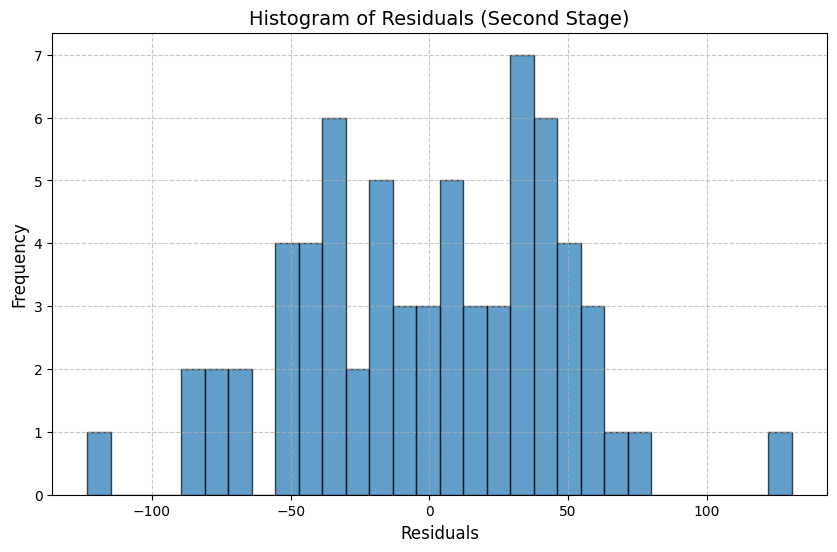

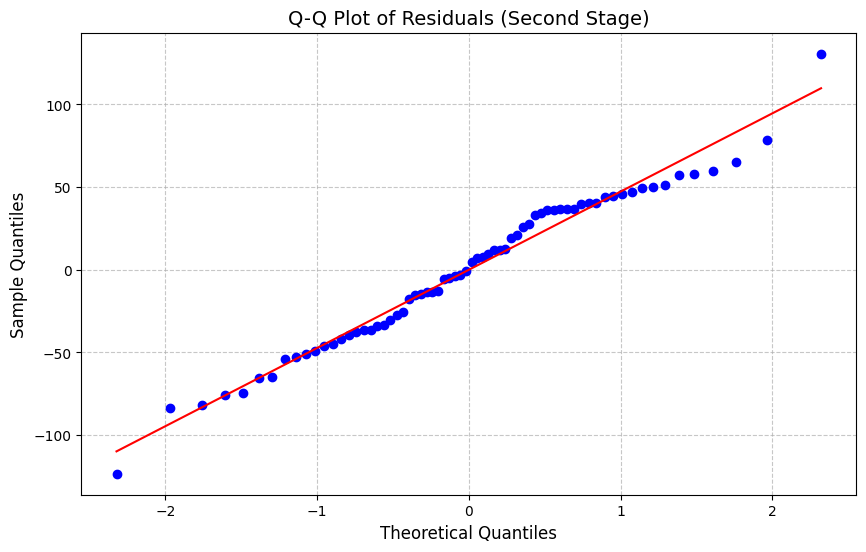

Shapiro-Wilk Test: Test Statistic = 0.9813, p-value = 0.3987
Kolmogorov-Smirnov Test: Test Statistic = 0.0989, p-value = 0.4880

Significant Coefficients (p < 0.05):
- mig_resid: Coefficient = -2.9938
  Interpretation: A 1-unit increase in mig_resid is associated with a -2.9938-unit decrease in ia_med_earnings_transformed.
Variance Inflation Factor (VIF) Analysis:
          Variable      VIF
pct_jobs_ort_resid 1.146764
         mig_resid 1.181437
  pct_sro_hu_resid 1.504376
     med_age_resid 1.128822
    pct_bach_resid 1.349894
 rec_vis_mil_resid 1.220697
    pop_size_resid 1.175280
                                 OLS Regression Results                                
Dep. Variable:     ia_med_earnings_transformed   R-squared:                       0.231
Model:                                     OLS   Adj. R-squared:                  0.141
Method:                          Least Squares   F-statistic:                     2.575
Date:                         Mon, 30 Dec 2024   Prob (F-

In [ ]:
## Regression analysis for income
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, kstest
import numpy as np
import pandas as pd

# Load the dataset
file_path = 'dataset_for_GNAR_only_regressions.csv'
data = pd.read_csv(file_path)

# Set up the panel data structure
data.set_index(['GEOID', 'year'], inplace=True)

# Define dependent and independent variables
dependent_var = 'ia_med_earnings_transformed'
independent_vars = [
    'pct_jobs_ort', 'mig', 'pct_sro_hu', 'med_age', 'pct_bach', 'rec_vis_mil', 'pop_size'
]
ti_independent_vars = ['VC_dist', 'GNAR_count']

# Step 1: First-stage regression
residuals = {}
for var in independent_vars:
    X_ti = sm.add_constant(data[ti_independent_vars])  # Add constant for time-invariant variables
    y = data[var]  # Current independent variable
    model_ti = sm.OLS(y, X_ti, missing='drop').fit()  # Handle missing data
    residuals[var] = model_ti.resid  # Store residuals

# Add residuals to the data frame as new variables
for var, res in residuals.items():
    data[f'{var}_resid'] = res

# Step 2: Second-stage regression
# Regress dependent variable on residualized independent variables
residualized_vars = [f'{var}_resid' for var in independent_vars]  # List of residualized variables
X_second_stage = sm.add_constant(data[residualized_vars])  # Add constant
y_second_stage = data[dependent_var]

model_second_stage = sm.OLS(y_second_stage, X_second_stage, missing='drop').fit()  # Handle missing data

# Plotting residuals to evaluate normality
plt.figure(figsize=(10, 6))
residuals_second_stage = model_second_stage.resid
plt.hist(residuals_second_stage, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals (Second Stage)', fontsize=14)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Q-Q Plot for residuals
plt.figure(figsize=(10, 6))
stats.probplot(model_second_stage.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Second Stage)', fontsize=14)
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Evaluate multicollinearity using VIF
# Remove rows with missing or infinite values in residualized variables
data_cleaned = data[residualized_vars].dropna()  # Drop rows with NaNs in residualized vars
data_cleaned = data_cleaned.replace([np.inf, -np.inf], np.nan).dropna()  # Remove infinities

# Ensure dependent variable matches cleaned data
X_cleaned = sm.add_constant(data_cleaned)

# Statistical Tests for Normality
# Shapiro-Wilk Test
shapiro_test_stat, shapiro_p_value = shapiro(residuals_second_stage)
print(f"Shapiro-Wilk Test: Test Statistic = {shapiro_test_stat:.4f}, p-value = {shapiro_p_value:.4f}")

# Kolmogorov-Smirnov Test
ks_test_stat, ks_p_value = kstest(residuals_second_stage, 'norm', args=(np.mean(residuals_second_stage), np.std(residuals_second_stage)))
print(f"Kolmogorov-Smirnov Test: Test Statistic = {ks_test_stat:.4f}, p-value = {ks_p_value:.4f}")

# Interpret Significant Coefficients
significant_coeffs = model_second_stage.pvalues[model_second_stage.pvalues < 0.05]
print("\nSignificant Coefficients (p < 0.05):")
for var in significant_coeffs.index:
    if var != 'const':  # Skip intercept
        coef = model_second_stage.params[var]
        print(f"- {var}: Coefficient = {coef:.4f}")
        if coef > 0:
            print(f"  Interpretation: A 1-unit increase in {var} is associated with a {coef:.4f}-unit increase in {dependent_var}.")
        else:
            print(f"  Interpretation: A 1-unit increase in {var} is associated with a {coef:.4f}-unit decrease in {dependent_var}.")

# Evaluate multicollinearity using VIF on cleaned data
X_vif = X_cleaned.drop(columns='const')  # Remove constant for VIF calculation
vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# Print the VIFs
print("Variance Inflation Factor (VIF) Analysis:")
print(vif_data.to_string(index=False))

# Export and display regression summary for reference
with open("/[YOUR LOCAL DRIVE HERE]/regression_summary_second_stage_income.csv", "w") as f:
    f.write(model_second_stage.summary().as_csv()) # Use summary().as_csv() to write to CSV

print(model_second_stage.summary())


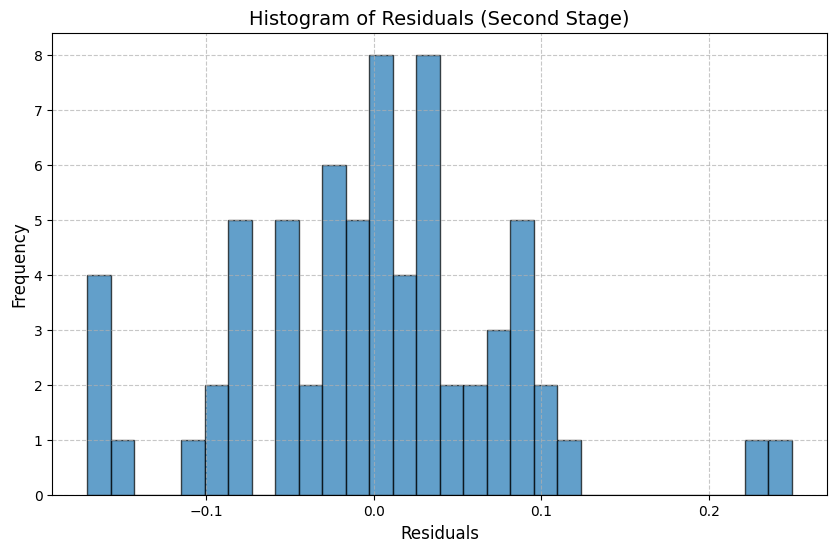

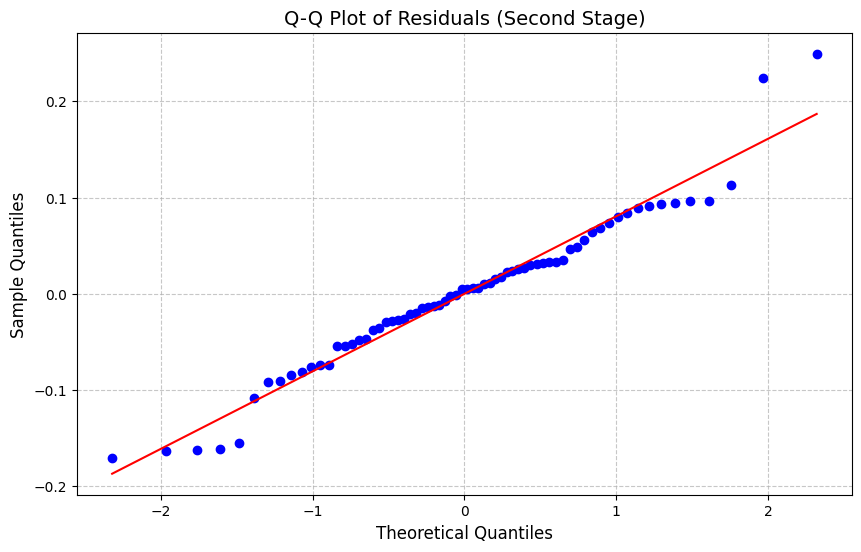

Shapiro-Wilk Test: Test Statistic = 0.9646, p-value = 0.0508
Kolmogorov-Smirnov Test: Test Statistic = 0.0809, p-value = 0.7347

Significant Coefficients (p < 0.05):
                            OLS Regression Results                            
Dep. Variable:                   gini   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9905
Date:                Mon, 30 Dec 2024   Prob (F-statistic):              0.453
Time:                        18:24:03   Log-Likelihood:                 75.355
No. Observations:                  68   AIC:                            -132.7
Df Residuals:                      59   BIC:                            -112.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err 

In [ ]:
## Regression analysis for income inequality
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, kstest
import numpy as np
import pandas as pd

# Load the dataset
file_path = 'dataset_for_GNAR_only_regressions.csv'
data = pd.read_csv(file_path)

# Set up the panel data structure
data.set_index(['GEOID', 'year'], inplace=True)

# Define dependent and independent variables
dependent_var = 'gini'
independent_vars = [
    'pct_jobs_ort', 'mig', 'pct_sro_hu', 'med_age', 'pct_bach', 'rec_vis_mil', 'pop_size', 'ia_med_earnings'
]
ti_independent_vars = ['VC_dist', 'GNAR_count']

# Step 1: First-stage regression
residuals = {}
for var in independent_vars:
    X_ti = sm.add_constant(data[ti_independent_vars])  # Add constant for time-invariant variables
    y = data[var]  # Current independent variable
    model_ti = sm.OLS(y, X_ti, missing='drop').fit()  # Handle missing data
    residuals[var] = model_ti.resid  # Store residuals

# Add residuals to the data frame as new variables
for var, res in residuals.items():
    data[f'{var}_resid'] = res

# Step 2: Second-stage regression
# Regress dependent variable on residualized independent variables
residualized_vars = [f'{var}_resid' for var in independent_vars]  # List of residualized variables
X_second_stage = sm.add_constant(data[residualized_vars])  # Add constant
y_second_stage = data[dependent_var]

model_second_stage = sm.OLS(y_second_stage, X_second_stage, missing='drop').fit()  # Handle missing data

# Plotting residuals to evaluate normality
plt.figure(figsize=(10, 6))
residuals_second_stage = model_second_stage.resid
plt.hist(residuals_second_stage, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals (Second Stage)', fontsize=14)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Q-Q Plot for residuals
plt.figure(figsize=(10, 6))
stats.probplot(model_second_stage.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Second Stage)', fontsize=14)
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Evaluate multicollinearity using VIF
# Remove rows with missing or infinite values in residualized variables
data_cleaned = data[residualized_vars].dropna()  # Drop rows with NaNs in residualized vars
data_cleaned = data_cleaned.replace([np.inf, -np.inf], np.nan).dropna()  # Remove infinities

# Ensure dependent variable matches cleaned data
X_cleaned = sm.add_constant(data_cleaned)

# Statistical Tests for Normality
# Shapiro-Wilk Test
shapiro_test_stat, shapiro_p_value = shapiro(residuals_second_stage)
print(f"Shapiro-Wilk Test: Test Statistic = {shapiro_test_stat:.4f}, p-value = {shapiro_p_value:.4f}")

# Kolmogorov-Smirnov Test
ks_test_stat, ks_p_value = kstest(residuals_second_stage, 'norm', args=(np.mean(residuals_second_stage), np.std(residuals_second_stage)))
print(f"Kolmogorov-Smirnov Test: Test Statistic = {ks_test_stat:.4f}, p-value = {ks_p_value:.4f}")

# Interpret Significant Coefficients
significant_coeffs = model_second_stage.pvalues[model_second_stage.pvalues < 0.05]
print("\nSignificant Coefficients (p < 0.05):")
for var in significant_coeffs.index:
    if var != 'const':  # Skip intercept
        coef = model_second_stage.params[var]
        print(f"- {var}: Coefficient = {coef:.4f}")
        if coef > 0:
            print(f"  Interpretation: A 1-unit increase in {var} is associated with a {coef:.4f}-unit increase in {dependent_var}.")
        else:
            print(f"  Interpretation: A 1-unit increase in {var} is associated with a {coef:.4f}-unit decrease in {dependent_var}.")

# Evaluate multicollinearity using VIF on cleaned data
X_vif = X_cleaned.drop(columns='const')  # Remove constant for VIF calculation
vif_data = pd.DataFrame({
    "Variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

# Print the VIFs
#print("Variance Inflation Factor (VIF) Analysis:")
#print(vif_data.to_string(index=False))

# Export and display regression summary for reference
with open("/[YOUR LOCAL DRIVE HERE]/regression_summary_second_stage_inequality.csv", "w") as f:
    f.write(model_second_stage.summary().as_csv()) # Use summary().as_csv() to write to CSV

print(model_second_stage.summary())